### Load data for one patient

In [4]:
from src.data.data_loader import BrisT1DDataLoader

PATIENT = "p04"


# Split up data into day and night
loader = BrisT1DDataLoader(use_cached=True)

train_df = loader.train_data[loader.train_data["p_num"] == PATIENT]
test_df = loader.validation_data[loader.validation_data["p_num"] == PATIENT]

TIME_STEP_SIZE = (
    train_df["datetime"].iloc[1] - train_df["datetime"].iloc[0]
).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

### Reduce columns and impute missing values on training set

In [5]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad')

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00",
        "steps-0:00",
        # "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

In [6]:
y_train, X_train = reduce_features(train_df)

### Config trainning parameterse


In [11]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
import numpy as np
import pandas as pd

# loss_callback = LossPlottingCallback()

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

training_samples = len(y_train)

BATCH_SIZE = 128
STEPS_PER_EPOCH = training_samples // BATCH_SIZE
NUM_TRAIN_EPOCH = 5000  # How many epochs to run
SAVE_EVERY_EPOCH = 100  # How many epochs to save
model = "TinyTimeMixer"


interval = "05mins" if TIME_STEP_SIZE == 5 else "15mins"
dir_path = f"../../src/models/ttm/{interval}/{PATIENT}/{current_time}"

ttm_forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": (60 // TIME_STEP_SIZE) * 18,  # 18 hours of context length
        "prediction_length": (60 // TIME_STEP_SIZE) * 6,  # 6 hours of prediction length
    },
    training_args={
        "num_train_epochs": NUM_TRAIN_EPOCH,
        "output_dir": dir_path,
        "use_cpu": False,
        "per_device_train_batch_size": BATCH_SIZE,
        "save_steps": STEPS_PER_EPOCH * SAVE_EVERY_EPOCH,
        # "callbacks": [],  # Add the callback here, why is this not working?
    },
)

print("selected interval: ", interval)
print(f"Training samples: {training_samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Every epoch has: {STEPS_PER_EPOCH} batches (or steps)")
print(f"Saving a checkpoint every {STEPS_PER_EPOCH * SAVE_EVERY_EPOCH} steps")

selected interval:  05mins
Training samples: 19018
Batch size: 128
Every epoch has: 148 batches (or steps)
Saving a checkpoint every 14800 steps


In [8]:
HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh = np.arange(1, NUM_STEPS + 1)

### Fit model on training set

In [ ]:
ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)

### Load the model at a given checkpoint and what patient to test
1. Change the model_path and checkpoint
2. Change the patient

In [147]:
import os

# Change these 2 values
model_path = f"../../src/models/ttm/05mins/{PATIENT}/2025-03-05_22-04-25"
checkpoint = 39

checkpoint_dirs = []

dirs = [d for d in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, d))]

for dir in dirs:
    if dir.startswith("checkpoint-"):
        checkpoint_dirs.append(model_path + "/" + dir)

# Sort checkpoints by number
checkpoint_dirs = sorted(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))
# print(checkpoint_dirs)


model_path = checkpoint_dirs[checkpoint]
print("Number of checkpoints: ", len(checkpoint_dirs))
print("model_path", model_path)

ttm_checkpoint = TinyTimeMixerForecaster(model_path=model_path)

# Extract checkpoint number from model path
checkpoint_num = int(model_path.split("-")[-1])
print(f"Using checkpoint {checkpoint_num}")
epoch_num = checkpoint_num // (STEPS_PER_EPOCH)
print(f"Epoch number: {epoch_num}")

Number of checkpoints:  40
model_path ../../src/models/ttm/05mins/p04/2025-03-05_22-04-25/checkpoint-585000
Using checkpoint 585000
Epoch number: 3952


### TinyTimeMixer


In [ ]:
# model = "TinyTimeMixer"

# zeroshot = False
# model_type = ""
# model_folder = f"TTM"

# if not zeroshot:
#     model_type = f"{4000} epochs"
#     forecaster = TinyTimeMixerForecaster(
#         model_path=model_path
#     )
# else:
#     model_type = f"ZeroShot"
#     forecaster = TinyTimeMixerForecaster()
# # forecaster.is_fitted


# forecaster.fit(y=y_train, X=X_train, fh=fh)


TinyTimeMixerForecaster(model_path='../../src/models/ttm/05mins/p04/2025-03-05_22-04-25/checkpoint-585000')

### ChronosForecaster

In [182]:
# from sktime.forecasting.chronos import ChronosForecaster

# model = "ChronosForecaster-Small"
# model_name = "amazon/chronos-t5-small"
# model_folder = "Chronos"

# forecaster = ChronosForecaster(
#     model_path = model_name,
#     config = {
#         "device": "cuda",
#     }
# )
# forecaster.fit(y=y_train, X=X_train, fh=fh)

### ARIMA

In [190]:
from sktime.forecasting.arima import ARIMA

model = "ARIMA"
model_folder = "ARIMA"

forecaster = ARIMA(order=(2, 0, 3))
forecaster.fit(y=y_train, X=X_train, fh=fh)

c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\sta

ARIMA(order=(2, 0, 3))

### Plot predicted glucose levels

In [191]:
def plot_predicted(ax, forecaster, fh, X_night, test_period):
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    ax.plot(test_period.index, predicted_bg, label="Predicted glucose levels")


def plot_intervals(ax, forecaster, fh, X_night, test_period):
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=0.95)[0][0.95]
    ax.plot(
        test_period.index,
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
    )

    ax.plot(
        test_period.index,
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
    )


def plot_quantiles(ax, forecaster, fh, X_night, test_period):
    quantiles = [0.95, 0.5, 0.05]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]

    ax.plot(
        test_period.index,
        pred_int[0.05],
        linestyle="--",
        label="0.05 quantile",
    )

    ax.plot(test_period.index, pred_int[0.50], label="0.5 quantile")

    ax.plot(
        test_period.index,
        pred_int[0.95],
        linestyle="--",
        label="0.95 quantile",
    )

c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

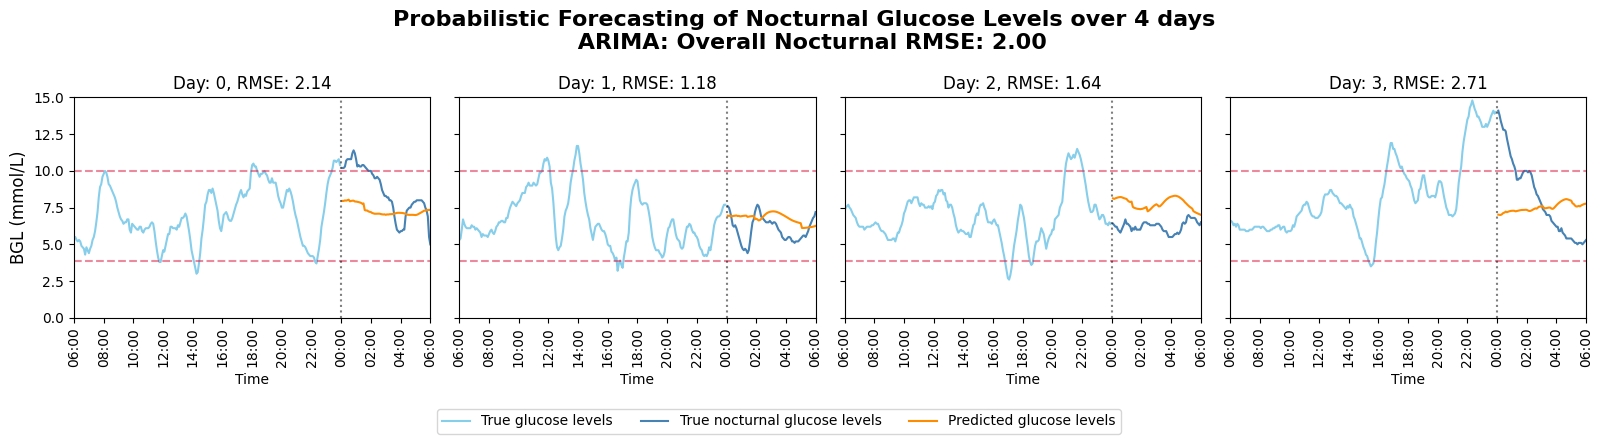

1.9165302935383743


In [192]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Create time index once (288 steps of 5 minutes from 6AM to 6AM next day)
time_index = pd.date_range(
    start="2024-01-01 06:00:00", end="2024-01-02 06:00:00", periods=289
)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Initialize the subplot counter
subplot_idx = 0
RMS_ERRORS = np.array([])
ERRORS_NIGHT = np.array([])

# Store lines for legend
legend_lines = []
legend_labels = []

idx = -1

# Loop over each day split and create one plot per day
for _, train_period, test_period in loader.get_validation_day_splits(PATIENT):
    idx += 1
    # if not (idx >= 10 and idx <= 13):
    start_idx = 13
    # if not (idx >= 10 and idx <= 13):
    if not (idx >= start_idx and idx <= start_idx + 3):
        continue
    y_day, X_day = reduce_features(train_period)
    y_night, X_night = reduce_features(test_period)

    if X_day.isna().sum().any() > 0:
        print(X_day)
    if X_night.isna().sum().any() > 0:
        print(X_night)

    # Update the model with the true glucose levels for the day
    forecaster.update(y=y_day, X=X_day, update_params=False)

    ######## Determine MSE between predicted and true glucose levels ########
    predicted_bg = forecaster.predict(fh=fh, X=X_night)

    ######## Plot true glucose levels ########
    ax = axes[subplot_idx]
    daystart = 216 - len(y_day)
    day_line = ax.plot(
        time_index[daystart : len(y_day) + daystart],
        y_day["bg-0:00"],
        color="skyblue",
        label="True glucose levels",
    )[0]
    night_line = ax.plot(
        time_index[-72:],
        y_night["bg-0:00"],
        color="steelblue",
        linestyle="-",
        label="True nocturnal glucose levels",
    )[0]

    predicted_bg_ax = ax.plot(
        time_index[-72:],
        predicted_bg,
        color="darkorange",
        linestyle="-",
        label="Predicted glucose levels",
    )[0]

    # Format x-axis
    ax.xaxis.set_major_locator(
        mdates.HourLocator(interval=2)
    )  # Show ticks every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM

    mse = np.sqrt(np.mean((predicted_bg.values - y_night["bg-0:00"].values) ** 2))
    SE_NIGHT = (predicted_bg.values - y_night["bg-0:00"].values) ** 2
    ERRORS_NIGHT = np.append(ERRORS_NIGHT, SE_NIGHT)
    RMS_ERRORS = np.append(RMS_ERRORS, mse)
    ax.set_title(f"Day: {subplot_idx}, RMSE: {mse:.2f}")

    ######## Plot predicted glucose levels ########
    # Only store legend items from first subplot
    if subplot_idx == 0:
        legend_lines.extend([day_line, night_line, predicted_bg_ax])
        legend_labels.extend(
            [
                "True glucose levels",
                "True nocturnal glucose levels",
                "Predicted glucose levels",
            ]
        )

    # Set limits to show full 24-hour period
    ax.set_xlim(time_index[0], time_index[-1])

    # Add labels and formatting for each subplot (remove legend)
    ax.set_xlabel("Time", fontsize=10)
    # Hide y-axis labels for all plots except first in each row
    if subplot_idx % 5 != 0:  # If not first plot in row
        ax.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("BGL (mmol/L)", fontsize=12)
    ax.set_ylim(0, 15.0)

    ax.tick_params(axis="x", rotation=90, labelsize=10)
    # Add horizontal reference lines
    ax.axhline(
        y=3.9, color="crimson", linestyle="--", alpha=0.5
    )  # Hypoglycemia threshold
    ax.axhline(
        y=10.0, color="crimson", linestyle="--", alpha=0.5
    )  # Hyperglycemia threshold
    ax.axvline(
        x=time_index[216], color="black", linestyle=":", alpha=0.5
    )  # Nocturnal start

    # Update the model with the true glucose levels for the night
    forecaster.update(y=y_night, X=X_night, update_params=False)

    # Increment the subplot index for the next day
    subplot_idx += 1

TOTAL_TEST_RMSE = np.sqrt(np.mean(ERRORS_NIGHT))

fig.suptitle(
    f"Probabilistic Forecasting of Nocturnal Glucose Levels over 4 days \n {model}: Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
    fontweight="bold",
    fontsize=16,
)

# Add a single legend outside the subplots
# fig.legend(legend_lines, legend_labels, ncols=1, bbox_to_anchor=(0.6, 0.0))
fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.7, 0.0))

# Adjust layout to avoid overlap with the legend
plt.tight_layout()


timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"{model_folder}/{model_folder}-{timestamp}.svg"
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(file_name), exist_ok=True)

plt.savefig(file_name, format="svg", dpi=1200, bbox_inches="tight")

# Show the figure with multiple subplots
plt.show()

print(RMS_ERRORS.mean())